In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Project Planning 

This project features two datasets from a real case.

For a year the client tested 4 different price points in the USA 6, 7, 8 and 9 dollars / month. I was asked to analyse the results of this pricing experiment and give recommendations based on what i found in the data.


1.User experiments: A sheet that indicates which users were put into which experiment variant and at which time it happened.
2.Users: A sheet with anonymized data on all users that were part of the experiment.

Discrepancies existed between the two datasets.
•	The two datasets contained uneven amounts of unique rows. 
•	Contained duplicate column names. 
To address these issues my approach was to rename one of the duplicate columns and then identify a unique key in the datasets. The key (id) was used to import the corresponding rows and columns in each dataset into a new dataset. 







```
#Tables have duplicate names renaming table colum
ALTER TABLE `Data.data_user`
RENAME COLUMN created_at TO creation_date;

#Merging the two datasets using the unique key located in each dataset.
CREATE TABLE `Data.data_exp_merged` AS
SELECT 
    data_exp.*,
    data_user.*
    
FROM `Data.data_exp` AS data_exp
JOIN `Data.data_user` AS data_user
ON data_exp.id = data_user.user_id;
```

No instructions or rules were given regarding the classification of a paying customer I decided to set these parameters myself. The logic I used was that a paying client cannot be a real client unless they meet the following criteria; 

```
CREATE TABLE `Data.data_exp_real` AS 
SELECT *
FROM `Data.data_exp_merged`
WHERE credit_card IS NOT NULL
AND subscribed_at IS NOT NULL
AND licenses IS NOT NULL;
```

The client wanted information related to churn and the datasets did not have information about churn stored as numbers or factors. Instead, the dataset contained a date as to when a client churned. This information was used to quantify churn. 

Lastly, I decided to verify that all four price groups that were being examined were still in the data and calculate the unique amount of participants ensuring my classification did not create an imbalance between groups using the query below. When summed up, the output is equal to the total amount of participants in the new dataset, confirming that we are not missing any participants and that there are no major imbalances between our four groups.

```
#creating Churned
CREATE TABLE `Data.data_exp_real_churn` AS
SELECT
  *,
  CASE
    WHEN subscription_ended_at IS NOT NULL THEN 1
    ELSE 0
  END AS churned
FROM
  `Data.data_exp_real`;
    
#Checking if the 4 diffrent groups still exist
SELECT MIN(assigned_alternative) AS MinValue, 
       MAX(assigned_alternative) AS MaxValue
FROM `Data.data_exp_real_churn`;

#calculating the amount of rows assinged to each price
SELECT assigned_alternative, COUNT(*) AS NumberOfUniqueRows
FROM `Data.data_exp_real_churn`
GROUP BY assigned_alternative
ORDER BY assigned_alternative;
```

After succefully extracting my data, merging the two datasets and manipulating some colums to generate information about chrun i procceded with using R. 

```
# Check the structure of the loaded data
str(data)
summary(data)

#only sample numeric data
numeric_data <- data[, sapply(data, is.numeric)]
correlation_matrix <- cor(numeric_data)
print(correlation_matrix)
```

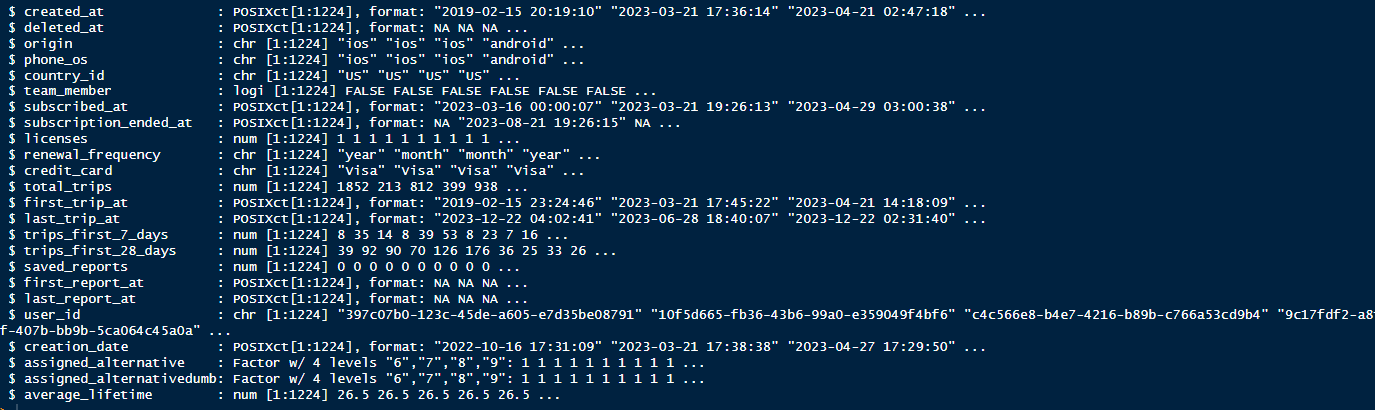


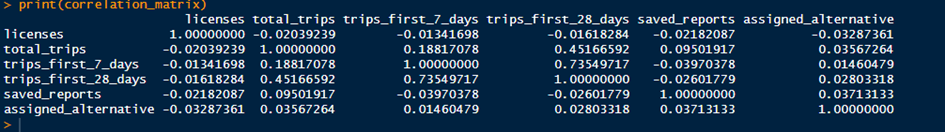

# MRR: What price point makes most money?

To estimate what pricepoint is making the most money without accounting for external variables (e,g  costs to acquire customers) I calculated the frequency of each group to determine the number of subscribers in each price group using the data_exp_real_churned dataset. I then multiplied the cost of each subscription fee and the number of subscribers to estimate the revenue/month. Note that this calculation does not account for customers who are in a specific price group and utilize a yearly subscription. The price group that generates the most amount of revenue per month is customers using the 9$ subscription. My client informes me about the customer lifetime span (26.54 months). I used this information to calculated each customer life-value (CLV) by multiplying the cost for subscription times the lifespan

```
#### CALCULATED Using AVRAGE LIFESPAN 
#Establish amount of groups + amount of particapants in each group 

num_groups <- n_distinct(data$assigned_alternative)
num_groups

group_counts <- data %>%
  group_by(assigned_alternative) %>%
  summarise(count = n())

group_counts

# Assign groups into new object
subscriber_counts <- table(data$assigned_alternative)
subscriber_data <- as.data.frame(subscriber_counts)

view(subscriber_data)

#Renaming colums
colnames(subscriber_data)[1] ="Price"
colnames(subscriber_data)[2] ="Amount_customers"

#Convert to numbers
subscriber_data$Price <- as.numeric(as.character(subscriber_data$Price))

subscriber_data$Amount_customers <- as.numeric(subscriber_data$Amount_customers)

### Establish the monthly revenue 

subscriber_data$monthly_revenue <- subscriber_data$Price * subscriber_data$Amount_customers
print(subscriber_data)

#Using Avrage customre lifespan 

data$average_lifetime <- 26.54 
view(data)

# Assuming the average lifetime is a constant
average_lifetime <- 26.54

# Calculating CLV for each group
subscriber_data$CLV <- subscriber_data$Price * 26.54

subscriber_data$Price <- as.numeric(as.character(subscriber_data$Price))
print(subscriber_data)
```



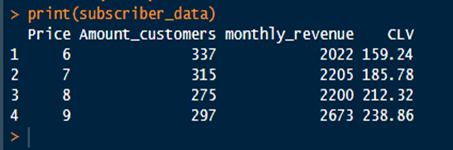

# Subscription: Is there a connection between price point and willingness to subscribe?

To assess the difference I used the unfiltered dataset (data_exp_merged). The model returns no significant difference between groups. However, the P-value is close to being significant. In a balanced dataset (number of subscribers and non-subscribers it is likely that there exists a significant difference. If the ANOVA had been significant I would proceed with post-hoc tests to identify which group contains the difference

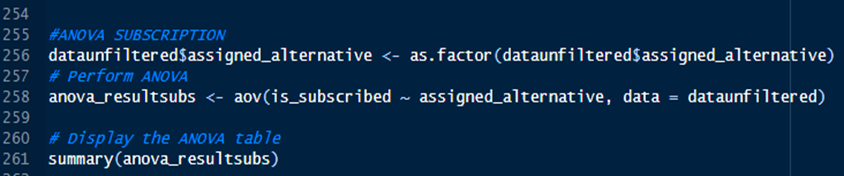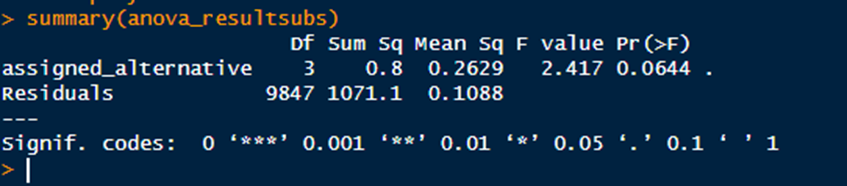!

# Do people cancel their subscriptions faster when the price is higher, and how does that affect overall earnings?

For this assessment, I used the filtered dataset (data_exp_real_churn). Taking into account the results of our previous model and knowing that price group 8 is underperforming in comparison to other parameters (e,g number of licenses and amount of churn, see looker report) 

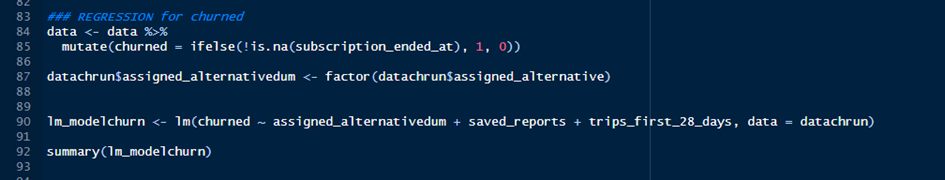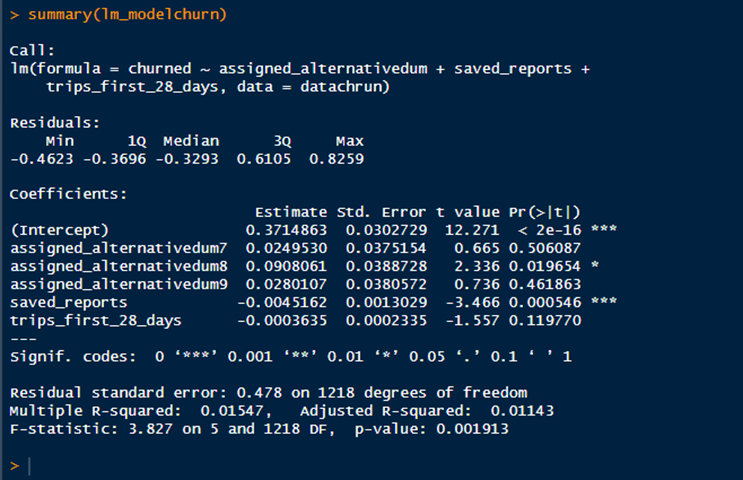!

The model returns Group 8 as a significant predictor indicating that there is a difference attributed to Group 8 in relation to churn behaviour. Additionally, saved reports were significant, implying as the number of saved_reports increases, the likelihood of churn tends to decrease. Promoting customers to save reports may decrease the likelihood of churn in the future. 

However, It's important to note that while this relationship is statistically significant, the actual impact (the size of the coefficient) is quite small, and the model's Adjusted R-squared value is low (1.1%), indicating that the model explains only a small portion of the variance in churn. For future reference, group 8 ought to be further studied (e.g. include other variables and run models using only data related to price group 8 to isolate new parameters that can be further used to explain churn behavior). Recommended analysis is mediation or moderation analysis. 


# Conclusions 
1. Price group 9 generates the most income / month. 
2. Price group 8 is the worst preforming priceplan. 
3. No significant diffrances between groups in regars to churn behaviour. 
4. Cheaper subscriptons (6 & 7 ) are associated with higher volume subscriptions.
5. There is no significant diffrance in driving behaviour between price plans (trips made).
4. Further parameters should be investagated in relation to price group 8 (e.g Total trips made or vehicle usage) 


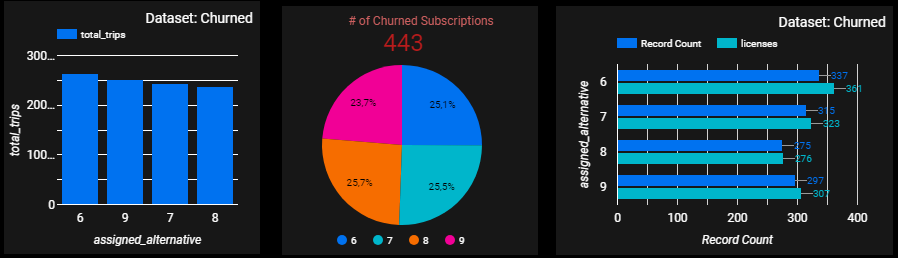
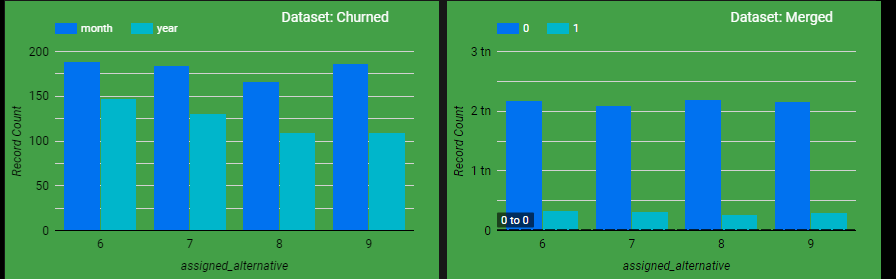
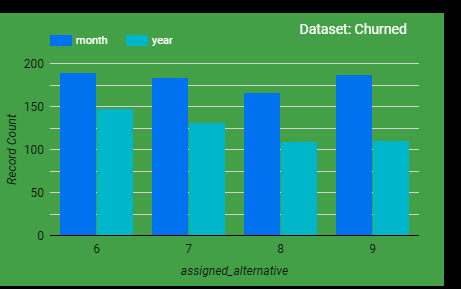